#  CNN 실습_이미지분류

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

* 함수 만들기

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 구글드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (3) 원본 데이터 둘러보기
* 공유받은 폴더 'CatsDogs'를 자신의 구글드라이브에 업로드 합니다.
* 업로드 위치 : 내드라이브 바로 아래!

* 데이터 목록 읽어오기

In [4]:
path = '/content/drive/MyDrive/CatsDogs/dogs'
fileList = os.listdir(path)

* 이미지 파일 둘러보기
    * 아래 셀을 반복실행해 봅시다.

(352, 500, 3)


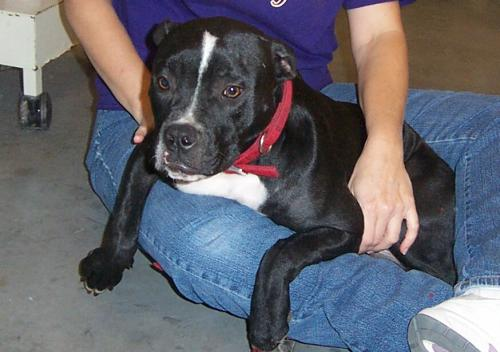

In [5]:
n = rd.randrange(0, len(fileList))
fileList[n]
file_r = path + '/' + fileList[n]
img = cv2.imread(file_r)
print(img.shape)
cv2_imshow(img)

## 2.이미지 전처리

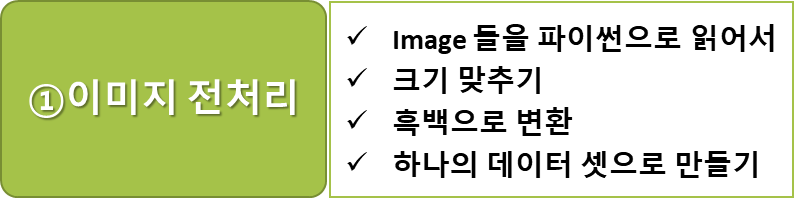

### (1) 파일 크기, 흑백 맞춰서 저장하기
* 흑백이미지
* 150 * 150 크기

* 아래 코드는 시간이 많이 소요되므로 이미 수행한 이미지를 사용합니다.
* 실제 데이터를 가지고 테스트할 때는 전처리를 수행해보게 됩니다.

In [ ]:
# path_r = '/content/drive/MyDrive/CatsDogs/cats'
# path_w = '/content/drive/MyDrive/CatsDogs/cats2'
# fileList = os.listdir(path_r)

# for idx, file in enumerate(fileList) :
#     file_r = path_r + '/' + file
#     img = cv2.imread(file_r, cv2.IMREAD_GRAYSCALE)  # 읽을때, 흑백으로 변환
#     img = cv2.resize(img, (150, 150))               # 크기 맞추기
#     file_w = path_w + '/' + str(idx) + '.jpg'
#     cv2.imwrite(file_w, img)                        # cats2에 저장
#     print(idx)

In [ ]:
# path_r = '/content/drive/MyDrive/CatsDogs/dogs'
# path_w = '/content/drive/MyDrive/CatsDogs/dogs2'
# fileList = os.listdir(path_r)

# for idx, file in enumerate(fileList) :
#     file_r = path_r + '/' + file
#     img = cv2.imread(file_r, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (150, 150))
#     file_w = path_w + '/' + str(idx) + '.jpg'
#     cv2.imwrite(file_w, img)
#     print(idx)

### (2) 하나의 데이터셋으로 만들기
* 약 2 ~ 5분 소요

In [9]:
# cat2
path = '/content/drive/MyDrive/CatsDogs/cats2/'
fileList = os.listdir(path)
cat_file = len(fileList)

for idx, file in enumerate(fileList) :
    file_name = path + '/' + file
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    if idx == 0 :
        x = img.reshape(1,150,150)
    else :
        x = np.concatenate((x, img.reshape(1,150,150)), axis=0)

In [10]:
# dog2
path = '/content/drive/MyDrive/CatsDogs/dogs2/'
fileList = os.listdir(path)
dog_file = len(fileList)

for idx, file in enumerate(fileList) :
    file_name = path + '/' + file
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    x = np.concatenate((x, img.reshape(1,150,150)), axis=0)

y = np.array([0] * cat_file + [1] * dog_file)
x.shape, y.shape

((5999, 150, 150), (5999,))

'999.jpg'

* [추가] 만약 데이터셋으로 저장하는 데 시간이 오래 걸리거나, 잘 안된다면 아래 코드를 실행해주세요.

In [ ]:
import joblib 

# 로딩하기
x_filename = '/content/drive/MyDrive/CatsDogs/x_catdog6000.pkl'
y_filename = '/content/drive/MyDrive/CatsDogs/y_catdog6000.pkl'

x = joblib.load(x_filename) 
y = joblib.load(y_filename)

x.shape, y.shape

((6000, 150, 150), (6000,))

## 3.모델링

### (1) 데이터 전처리

* 데이터 분할

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 1000)
x_train.shape, x_val.shape

((4999, 150, 150), (1000, 150, 150))

* 모델 입력(input_shape)에 맞게 차원 조절

In [12]:
x_train = x_train.reshape(-1, 150, 150, 1)
x_test = x_val.reshape(-1, 150, 150, 1)

In [13]:
x_train.shape, x_val.shape

((4999, 150, 150, 1), (1000, 150, 150))

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train, x_test를 그냥 255로 나누면 됨

In [14]:
x_train = x_train / 255.
x_val = x_val / 255.

### (2) 모델링 
* 아래 구조와 동일하거나 조금 변형해서 모델링을 수행해 봅시다.

In [41]:
clear_session()

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
# GPU 버전에서 약 2 분 소요(GPU를 쓸 수 없다면 20분 이상 소요)
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics = 'accuracy')

history = model.fit(x_train, y_train, epochs = 30, batch_size = 128, validation_split=0.2).history

* 학습결과 그래프

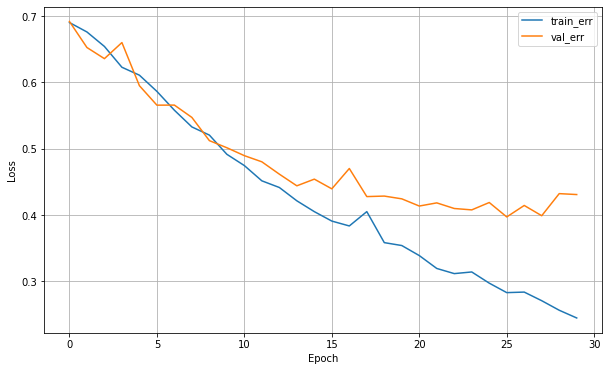

In [43]:
dl_history_plot(history)

* [추가] 만약 학습시간이 너무 오래 걸린다면, 아래 코드로 이미 만든 모델을 로딩합니다.

In [49]:
model = load_model('/content/drive/MyDrive/CatsDogs/model.h5')

In [50]:
# 예측
pred = model.predict(x_val)
pred = np.where(pred > 0.5, 1, 0)

# 평가
print(f'Accuracy : {accuracy_score(y_val, pred)}')
print('-' * 60)
print('<< Confusion Matrix >>\n')
print(confusion_matrix(y_val, pred))
print('-' * 60)
print(classification_report(y_val, pred))

Accuracy : 0.872
------------------------------------------------------------
<< Confusion Matrix >>

[[411 105]
 [ 23 461]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       516
           1       0.81      0.95      0.88       484

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



## 4.틀린 이미지 찾아보기

In [51]:
pred.shape, y_val.shape

((1000, 1), (1000,))

In [52]:
idx = (y_val != pred.reshape(1000,))
x_val_wr = x_val[idx]
y_val_wr = y_val[idx]
pred_wr = pred[idx].reshape(-1,)

x_val_wr = x_val_wr.reshape(-1,150,150)
print(x_val_wr.shape)

(128, 150, 150)


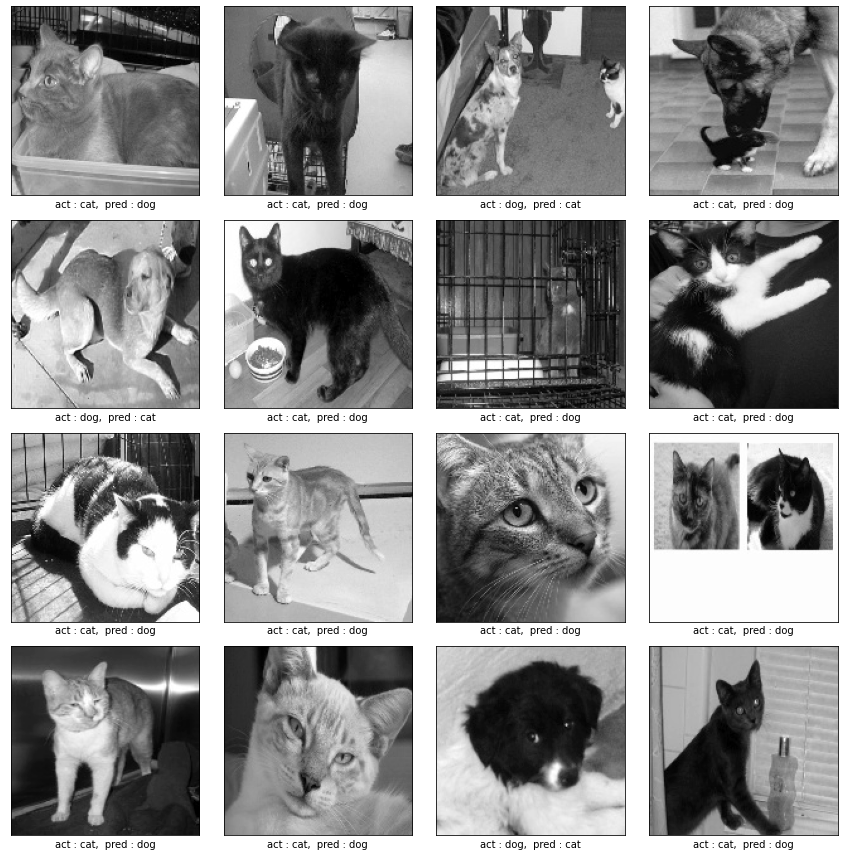

In [53]:
idx = rd.sample(range(x_val_wr.shape[0]),16)
x_temp = x_val_wr[idx]
y_temp = y_val_wr[idx]
p_temp = pred_wr[idx]
class_name = ['cat','dog']

plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(1-x_temp[i], cmap=plt.cm.binary)
    plt.xlabel(f'act : {class_name[y_temp[i]]},  pred : {class_name[p_temp[i]]}')
plt.tight_layout()
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/CatsDogs/model.h5')

## 5.인터넷에서 이미지를 찾아 테스트해봅시다.

### (1) 이미지 다운받아 구글드라이브에 올리기
* 인터넷에서 고양이/강아지 이미지 몇 개를 다운 받습니다.
* 콜랩, 왼쪽 탭 중 파일 선택하고
* 이미지를 드래그 & 드롭으로 업로드

### (2) 이미지 전처리

(420, 600, 3)


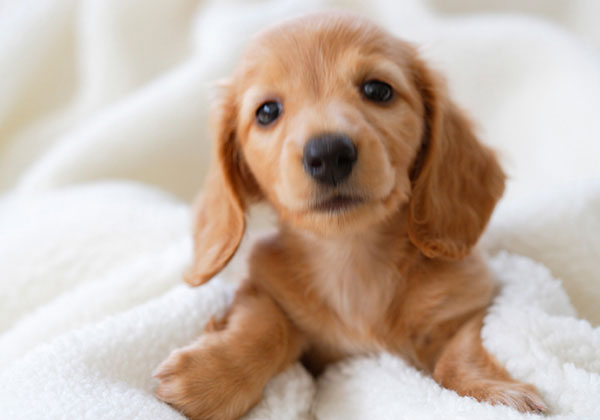

In [60]:
# 아래 file_name을 여러분이 업로드한 파일 이름으로 수정합니다.
file_name = 'dog011.jpg'

# 업로드한 이미지 확인하기
img = cv2.imread(file_name)
print(img.shape)
cv2_imshow(img)


(150, 150)


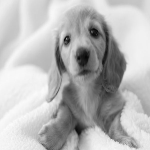

In [61]:
# 이미지 전처리
# 흑백으로 다시 로딩
img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 

# 사이즈 조정
img = cv2.resize(img, (150, 150))               # 크기 맞추기
print(img.shape)
cv2_imshow(img)

In [62]:
class_name = ['cat','dog']

# 입력데이터 형식을 갖추기
test_num = img.reshape(1,150,150,1)

# 예측하기(예측된 값이 2차원, float 타입이어서, 1차원 변환)
pred = model.predict(test_num).reshape(-1,)

# 예측결과 0,1 추출, class 이름으로 변환
class_name[int(pred[0])] 

'dog'